In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('weather-2021-preprocessed.csv')
df.head()

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Description,UV Index,Condition
0,2021-01-01 00:00:00,75,75.0,75.0,61.0,61.0,6.0,8,29.85,Low,0,Cloudy
1,2021-01-01 00:30:00,75,75.0,75.0,61.0,61.0,6.0,7,29.85,Low,0,Cloudy
2,2021-01-01 01:00:00,75,75.0,75.0,61.0,61.0,6.0,7,29.82,Low,0,Cloudy
3,2021-01-01 01:30:00,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy
4,2021-01-01 02:00:00,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy


# PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU

## A. Mô hình hóa dữ liệu và huấn luyện mô hình

### Giới thiệu bài toán
Dựa trên việc tìm hiểu về bộ dữ liệu thông qua các quá trình khám phá dữ liệu và đặt các câu hỏi có ý nghĩa cần trả lời, bài toán thích hợp cho bộ dữ liệu này là 'Dự đoán điều kiện thời tiết có phải là nhiều mây hay không?'

Lý do lựa chọn thuật toán phân lớp (Classification Algorithm)

Phân tích và lựa chọn ra những đặc trưng có mức độ liên quan cao, có tính quan trọng cho bài toán

Tiền xử lý các thuộc tính

In [5]:
df_copy = df.copy()

<AxesSubplot:xlabel='Condition', ylabel='count'>

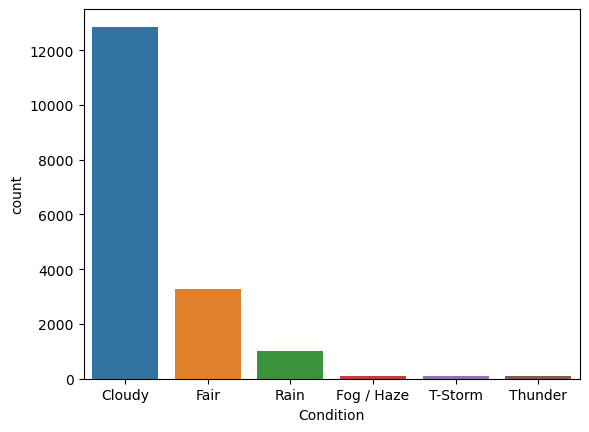

In [6]:
sns.countplot(x='Condition', data=df_copy)

In [138]:
# Import LabelEncoder
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
df_copy['Condition'] = le.fit_transform(df_copy['Condition'])
df_copy['UV Description'] = le.fit_transform(df_copy['UV Description'])
df_copy['Time'] = pd.to_datetime(df_copy['Time'])
df_copy['Time'] = df_copy['Time'].dt.month
df_copy

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Description,UV Index,Condition
0,1,75,75.0,75.0,61.0,61.0,6.0,8,29.85,2,0,0
1,1,75,75.0,75.0,61.0,61.0,6.0,7,29.85,2,0,0
2,1,75,75.0,75.0,61.0,61.0,6.0,7,29.82,2,0,0
3,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,2,0,0
4,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17385,12,81,82.0,82.0,64.0,58.0,6.0,8,29.94,2,0,0
17386,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,2,0,0
17387,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,2,0,0
17388,12,79,81.0,81.0,64.0,61.0,6.0,8,29.94,2,0,0


In [139]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17390 entries, 0 to 17389
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    17390 non-null  int64  
 1   Temperature             17390 non-null  int64  
 2   Heat Index              17388 non-null  float64
 3   Temperature Feels Like  17388 non-null  float64
 4   Dew Point               17388 non-null  float64
 5   Humidity                17388 non-null  float64
 6   Wind Force              17390 non-null  float64
 7   Wind Speed              17390 non-null  int64  
 8   Pressure                17380 non-null  float64
 9   UV Description          17390 non-null  int32  
 10  UV Index                17390 non-null  int64  
 11  Condition               17390 non-null  int32  
dtypes: float64(6), int32(2), int64(4)
memory usage: 1.5 MB


In [140]:
df_copy.isnull().sum()

Time                       0
Temperature                0
Heat Index                 2
Temperature Feels Like     2
Dew Point                  2
Humidity                   2
Wind Force                 0
Wind Speed                 0
Pressure                  10
UV Description             0
UV Index                   0
Condition                  0
dtype: int64

In [141]:
missing_cols = df.columns[df.isnull().any()]

In [142]:
mean = df_copy.groupby('Condition').mean()
mean

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Description,UV Index
Condition,,,,,,,,,,,
0,6.924315,83.087897,89.488255,89.488255,74.489966,77.177116,5.554838,5.766490,29.754057,2.171749,2.028936
1,4.512247,82.007961,86.613595,86.613595,71.213411,71.656767,5.625842,6.134415,29.795993,2.136865,1.859767
2,6.258427,78.539326,80.966292,80.966292,74.528090,89.134831,1.593933,2.359551,29.813596,2.168539,1.337079
3,7.787362,80.347041,85.548193,85.548193,76.720884,89.754016,4.364343,6.597793,29.723861,2.201605,1.989970
4,7.160000,77.840000,80.990000,80.990000,75.980000,94.400000,2.003500,11.320000,29.731500,2.200000,1.660000
5,7.341463,84.829268,93.493827,93.493827,75.864198,75.493827,5.304878,7.536585,29.712073,2.390244,2.560976


In [143]:
for col in missing_cols:
    df_copy[col] = df_copy[col].fillna(df_copy['Condition'].map(mean[col]))

In [144]:
df_copy.isnull().sum()

Time                      0
Temperature               0
Heat Index                0
Temperature Feels Like    0
Dew Point                 0
Humidity                  0
Wind Force                0
Wind Speed                0
Pressure                  0
UV Description            0
UV Index                  0
Condition                 0
dtype: int64

## B. Đánh giá mô hình

KNN Classification

In [145]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

features = df_copy[['Time', 'Temperature', 'Heat Index', 'Temperature Feels Like', 'Dew Point', 'Humidity', 'Wind Force', 'Wind Speed', 'Pressure', 'UV Description', 'UV Index']]
label = df_copy['Condition']

# Train the model using the training sets
model.fit(features,label)

#Predict Output
predicted= model.predict([[1, 75, 75.0, 75.0, 61.0, 61.0, 6.0, 8, 29.85, 2, 0]])
print(predicted)

[0]


c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Naive Bayes Classification